# OpenStreetMap DATA Case

# 地图

Las Vegas, United States

https://www.openstreetmap.org/node/31551114#map=10/36.1673/-115.1491

https://mapzen.com/data/metro-extracts/metro/las-vegas_nevada/

选择拉斯维加斯是因为一直想去，所以也希望借此机会能为它做一些贡献

# 处理数据过程遇到的问题

1，发现v值的不均匀性，选择改善街道名,即将缩写结尾的改成street,way等的全拼。

2，在习题中，update_name 函数我的解决方案如下：

In [ ]:
def update_name(name, mapping):

    # 用find在name中找到mapping中每个mapp，所以这里的逻辑应该是有问题的，函数并不只在name 的结尾处查找，
    #所以有可能前面的街道名字中含有mapp，而返回错误的值
    for mapp in mapping:
        if name.find(mapp)>0:
            return (name.replace(mapp,mapping[mapp]))

在做习题的时候并没有报错，用我利用课程提供的函数生成的样本也可以，但用真正完整的数据处理时，报错如下：

In [ ]:
Traceback (most recent call last):

  File "<ipython-input-33-d93e72dc15d5>", line 1, in <module>
    runfile('C:/data analysis/data_2/las-vegas_nevada.osm/sample_project.py', wdir='C:/data analysis/data_2/las-vegas_nevada.osm')

  File "C:\Anaconda2\lib\site-packages\spyder\utils\site\sitecustomize.py", line 710, in runfile
    execfile(filename, namespace)

  File "C:\Anaconda2\lib\site-packages\spyder\utils\site\sitecustomize.py", line 86, in execfile
    exec(compile(scripttext, filename, 'exec'), glob, loc)

  File "C:/data analysis/data_2/las-vegas_nevada.osm/sample_project.py", line 75, in <module>
    street_types=audit(OSMFILE)

  File "C:/data analysis/data_2/las-vegas_nevada.osm/sample_project.py", line 60, in audit
    for event, elem in ET.iterparse(osm_file, events=("start",)):

  File "<string>", line 103, in next

IndexError: pop from empty stack

百度上看了一下，是关于栈的设置出了问题，同时我在论坛上发现我的update_name 函数并不完整，改善后的函数如下：

In [ ]:
def update_name(name, mapping):

    # 用endswith能够确保只是对name最后结尾的字符进行判断
    for mapp in mapping:
        if name.endswith(mapp):
            return name.replace(mapp,mapping[mapp])
            print(name)

4，同时，改善街道名的函数需要结合到shape_element函数中，仔细研读了audit_street_type，is_street_name(elem)，audit(osmfile)函数，总结了几点：
1),audit_street_type，is_street_name(elem)，是对elem即单个元素进行定义，而audit(osmfile)其实是将前面两个函数结合起来解析数据。
2)，并不是要直接改OSM 中的数据，而是改我们解析到内存中的数据，然后写入CSV,所以重点是改善解析进内存的街道名，于是我结合了两个函数改了shape_element函数如下：

In [ ]:
def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""
    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    for tag in element.iter('tag'):
        if is_street_name(tag):#判断v的格式
            m = street_type_re.search(tag.attrib['v'])#正则判断
            if m:
                street_type = m.group()#取v的结尾字符
                if street_type not in expected:
                    tag.attrib['v']=update_name(tag.attrib['v'], mapping)#替换v值
                    print tag.attrib['v']
        new_tag = shape_tag(element,tag)
        if new_tag:
             tags.append(new_tag)#填充之前定义的空列表
        
    if element.tag=='node':
        node_attribs={f:element.attrib[f] for f in node_attr_fields}
        return {'node':node_attribs,'node_tags':tags}
        
    elif element.tag=='way':
        way_attribs={f:element.attrib[f] for f in way_attr_fields}
        way_nodes=[shape_way_node(element,i,nd) for i,nd in enumerate(element.iter('nd'))]
        return {'way':way_attribs,'way_nodes':way_nodes,'way_tags':tags}

3,关于验证的原题，习题中的验证用到了本地一直不行，Schema 一直报错，于是用了论坛上的方法，注释掉验证.

# 数据概述

1，文件大小，磁盘数据如下：

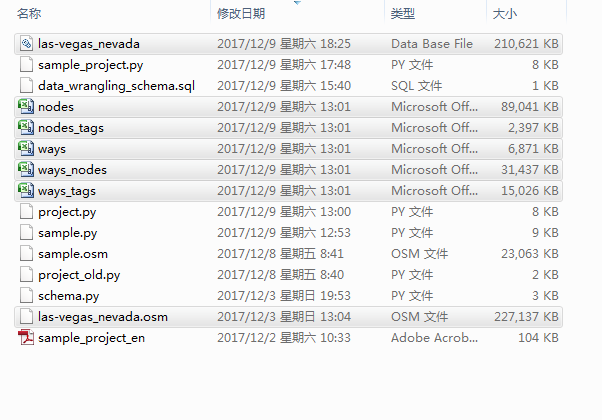

2，唯一用户的数量：1010

In [ ]:
select count(*) from(select uid, count(*) from nodes group by uid) as ab;

3，节点（key）的数量：431068

In [ ]:
select count(key) from ways_tags;

4,节点类型为咖啡厅的数量：400

In [ ]:
select count(*) from nodes_tags where key="cuisine";

5，找出50个咖啡店的纬度：

In [ ]:
select nodes.lat from nodes, nodes_tags where nodes.id=nodes_tags.id and nodes_tags.key=”cuisine”limit 50；

# 关于数据集规范性的其他想法

建议：从现在的数据集中的v值和k值可以看出，对于k值和v值是没有定义类型的，其中有店名，道路名，不同语言等等，这样的数据很不规范，也不好分析，建议对k值和v值的输入设置更多子属性

好处：数据能够更加清晰明朗，比如v值分为更大类别，大类别下再分为小类别，方便数据分析，如

地点信息：城市信息/街道信息等分类

店铺类型信息：店铺类型/店名/地址

。。。。

缺点：可能会出现很多空集，因为并不是所有用户都知道所有的信息，在清理数据时需要注意这些空集的存在

# 参考

1，Udacity 论坛
2，The Python Standard Library